# Введение в нейронные сети

## Урок 8. GAN

Обучите нейронную сеть любой архитектуры на каком-то производственном датасете.  
Сделайте анализ того, что вам помогло в улучшения работы нейронной сети.  
Можно выполнить сегментацию по Северстали.  
В конце, обязательно подвести вывод.

---

Т.к. вычислетельные мощности ограничен, вернемся к менее ресурсоемким задачам.  
Попробуем сегментирвать изображение домашних животных из датасета Oxford-IIIT Pet Dataset, с использованием модифицированной версии U-Net.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-7bc6gobj
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-7bc6gobj
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done


In [ ]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds

import keras
from keras import utils
from keras.losses import SparseCategoricalCrossentropy


from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

### Загрузка датасета

Oxford-IIIT Pet Dataset входит в набор датасетов TensorFlow, но необходимо установить модуль tensorflow-datasets.

In [ ]:
#Download the Oxford-IIIT Pets dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*',shuffle_files=True , with_info=True)

In [ ]:
# нормализация изобюражения
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1  # пиксели сегментационной маски помечаем как {0, 1, 2}
  return input_image, input_mask

Следующий код выполнит простую аугументацию данных посредством переворота изображений.

In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  # data augmentation
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
# transform for test data
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

Датасет уже содержит необходимые тестовый и тренеровочный сплиты, поэтому будем использовать их.

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32 #64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

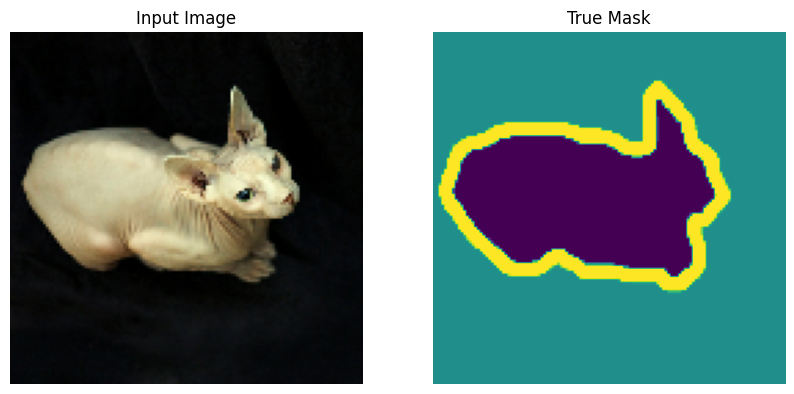

In [ ]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

### Создание модели

Будем использовать модифицированный U-Net.

Для ускорения процесса обучения в качестве энкодера будет использоваться предобученный MobileNetV2.  
Энкодер состоит из определенных аутпутов из средних слоев модели и не будет участвовать в процессе тренировки модели.

Для декодера, мы будем использовать повышающий дискретизацию блок, который уже реализован в Pix2pix.

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
from keras.applications import MobileNetV2 # MobileNetV3Large, ResNet50,
from keras import Model # layers, losses

# base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights="imagenet", pooling="max")
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False)

# Use the activations of these layers
layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

In [ ]:
down_stack.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_7[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']      

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
from keras.layers import Input, Concatenate, Conv2DTranspose
from keras import regularizers

def unet_model(output_channels):
  inputs = Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = Concatenate() # take an object
    x = concat([x, skip])

  # This is the last layer of the model
  last = Conv2DTranspose(
      OUTPUT_CHANNELS, 3, strides=2,
      padding='same',  #64x64 -> 128x128
      activation='silu',
      #kernel_initializer="he_uniform",
      kernel_regularizer=regularizers.L2(0.001),
  )

  x = last(x)

  return Model(inputs=inputs, outputs=x)

### Тренировка модели

Нейросеть пытается назначить каждому пикселю лейбл, также как в задачах предсказания класса. Для модели в которой 3 каннала каждый из которых пытается предсказать класс обычно рекомендуется использовать функцию потерь `SparseCategoricalCrossentropy(from_logits=True)`.

In [ ]:
model = unet_model(OUTPUT_CHANNELS)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.91, beta_2=0.998),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_6 (Functional)        [(None, 64, 64, 96),         1841984   ['input_8[0][0]']             
                              (None, 32, 32, 144),                                                
                              (None, 16, 16, 192),                                                
                              (None, 8, 8, 576),                                                  
                              (None, 4, 4, 320)]                                                  
                                                                                            

Посмотрим на получившуюся архитектуру модели.

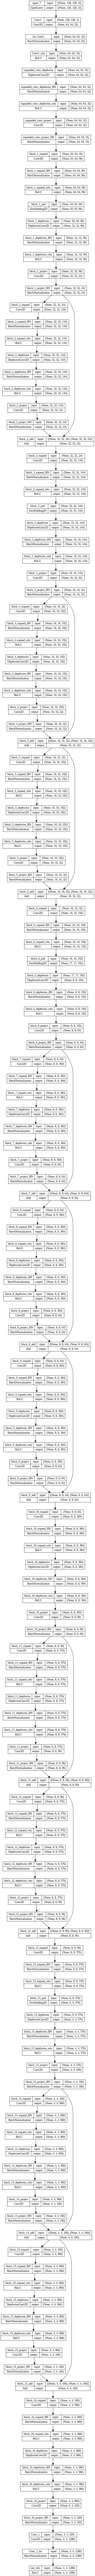

In [ ]:
utils.plot_model(base_model, show_shapes=True)

На выходе нейросети каждому пикселю назначается лейбл с наибольшим значением.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

Попробуем сделать предсказание с помощью нашей модели до того как началось обучение.

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 1s/step


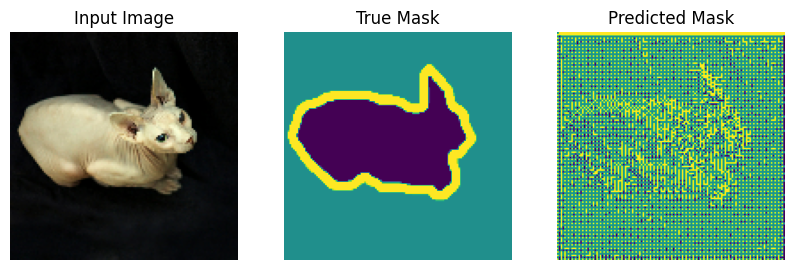

In [ ]:
show_predictions()

Будем мониторировать улучшение работы модели в процессе обучения. Для этого определим callback-функцию.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/10
1/1 [==============================] - 0s 24ms/step


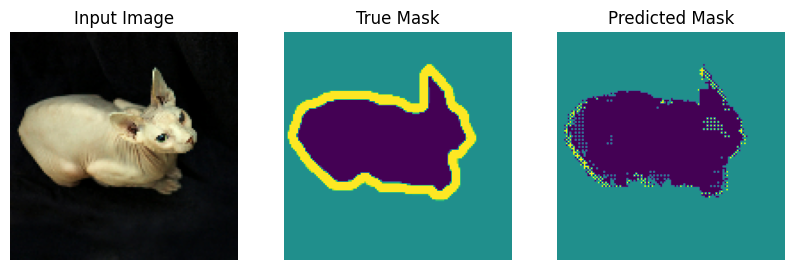


Sample Prediction after epoch 1

115/115 [==============================] - 21s 121ms/step - loss: 0.4872 - accuracy: 0.8134 - val_loss: 0.4181 - val_accuracy: 0.8386
Epoch 2/10
1/1 [==============================] - 0s 22ms/step


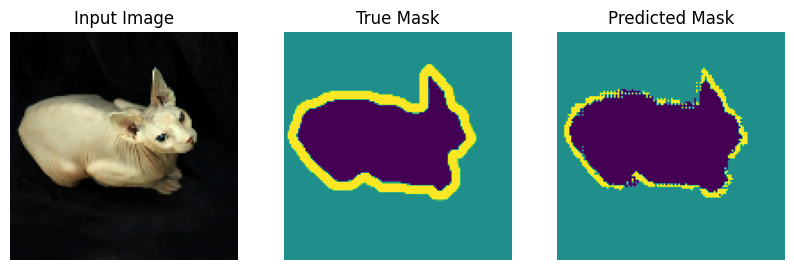


Sample Prediction after epoch 2

115/115 [==============================] - 9s 79ms/step - loss: 0.3783 - accuracy: 0.8601 - val_loss: 0.3871 - val_accuracy: 0.8638
Epoch 3/10
1/1 [==============================] - 0s 21ms/step


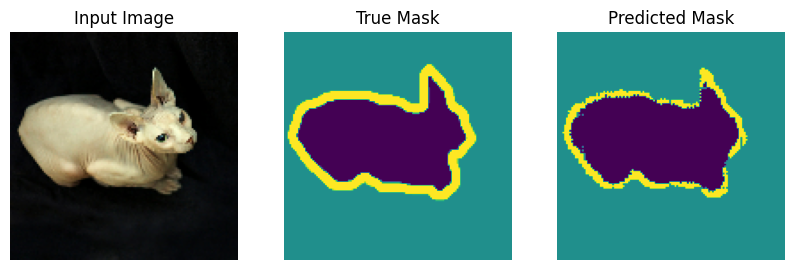


Sample Prediction after epoch 3

115/115 [==============================] - 10s 87ms/step - loss: 0.3585 - accuracy: 0.8785 - val_loss: 0.3827 - val_accuracy: 0.8686
Epoch 4/10
1/1 [==============================] - 0s 34ms/step


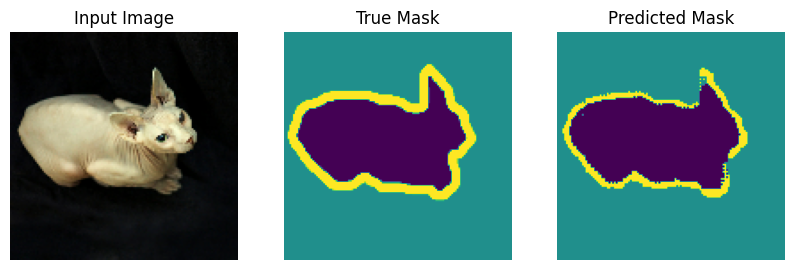


Sample Prediction after epoch 4

115/115 [==============================] - 10s 88ms/step - loss: 0.3475 - accuracy: 0.8841 - val_loss: 0.3735 - val_accuracy: 0.8754
Epoch 5/10
1/1 [==============================] - 0s 23ms/step


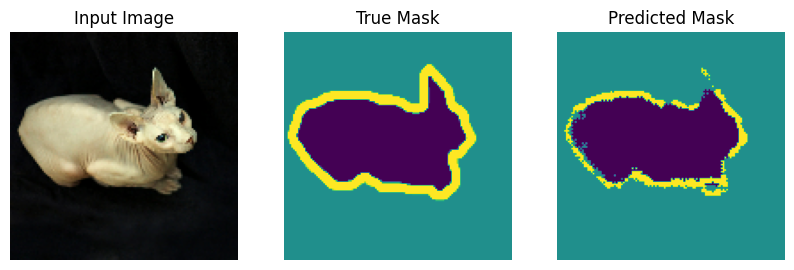


Sample Prediction after epoch 5

115/115 [==============================] - 10s 88ms/step - loss: 0.3402 - accuracy: 0.8878 - val_loss: 0.3925 - val_accuracy: 0.8597
Epoch 6/10
1/1 [==============================] - 0s 21ms/step


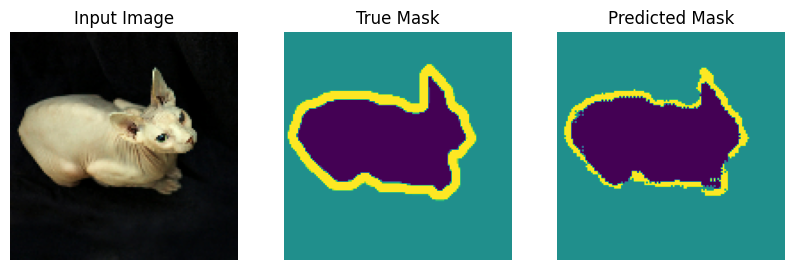


Sample Prediction after epoch 6

115/115 [==============================] - 9s 80ms/step - loss: 0.3363 - accuracy: 0.8893 - val_loss: 0.3815 - val_accuracy: 0.8716
Epoch 7/10
1/1 [==============================] - 0s 22ms/step


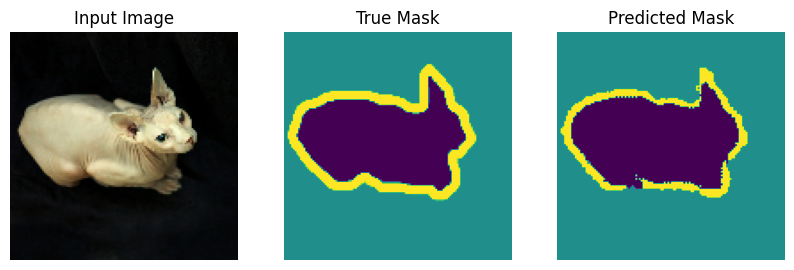


Sample Prediction after epoch 7

115/115 [==============================] - 10s 87ms/step - loss: 0.3267 - accuracy: 0.8935 - val_loss: 0.3673 - val_accuracy: 0.8856
Epoch 8/10
1/1 [==============================] - 0s 22ms/step


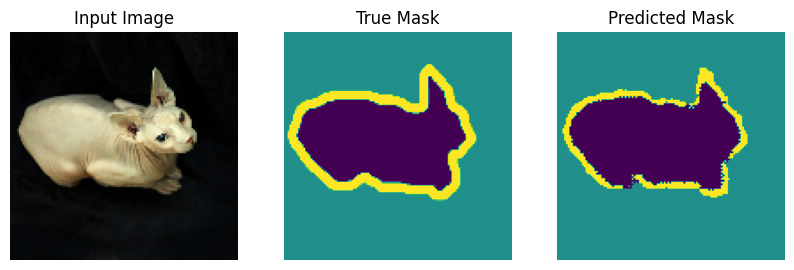


Sample Prediction after epoch 8

115/115 [==============================] - 9s 80ms/step - loss: 0.3221 - accuracy: 0.8957 - val_loss: 0.3675 - val_accuracy: 0.8826
Epoch 9/10
1/1 [==============================] - 0s 36ms/step


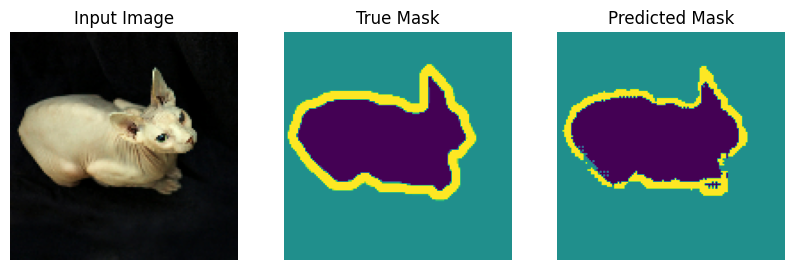


Sample Prediction after epoch 9

115/115 [==============================] - 10s 87ms/step - loss: 0.3162 - accuracy: 0.8981 - val_loss: 0.3819 - val_accuracy: 0.8733
Epoch 10/10
1/1 [==============================] - 0s 21ms/step


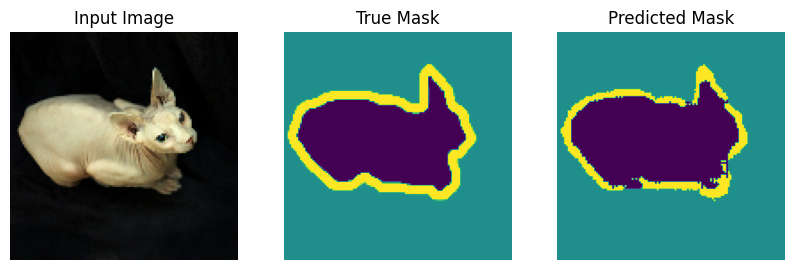


Sample Prediction after epoch 10

115/115 [==============================] - 9s 79ms/step - loss: 0.3088 - accuracy: 0.9013 - val_loss: 0.3670 - val_accuracy: 0.8870


In [ ]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          verbose = 1,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

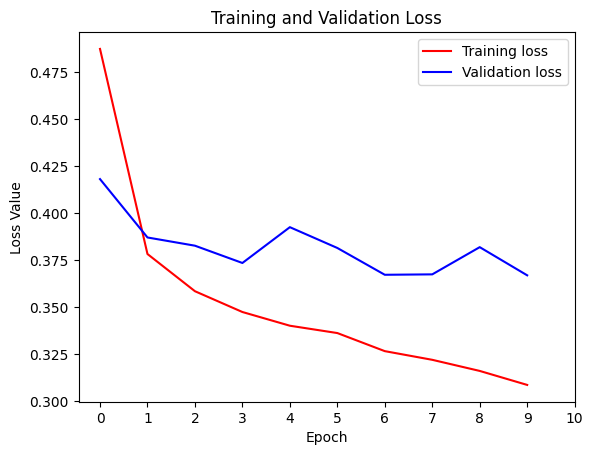

In [ ]:
plt.plot(model_history.history['loss'], 'r', label='Training loss')
plt.plot(model_history.history['val_loss'], 'b', label='Validation loss')
plt.xticks(np.arange(0, EPOCHS+1, 1.0))
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend();

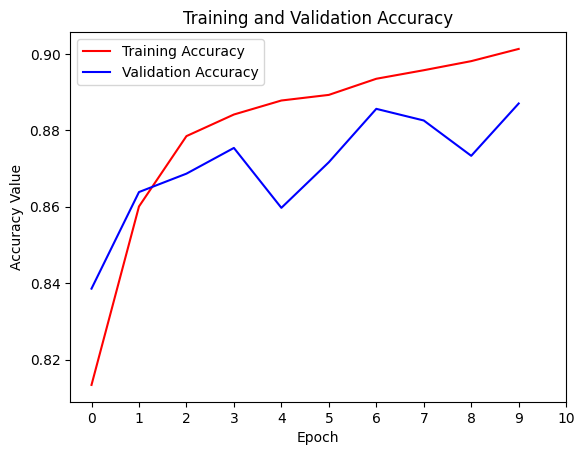

In [ ]:
plt.plot(model_history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.xticks(np.arange(0, EPOCHS+1, 1.0))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend();

1/1 [==============================] - 0s 111ms/step


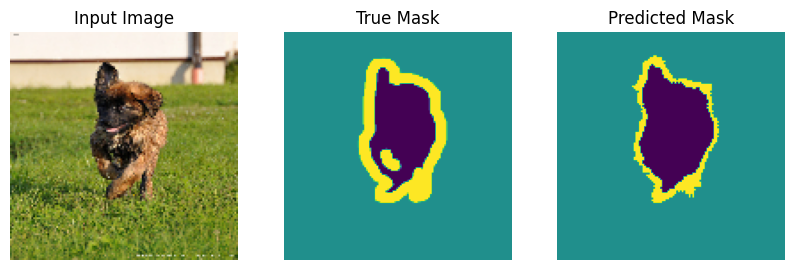

1/1 [==============================] - 0s 100ms/step


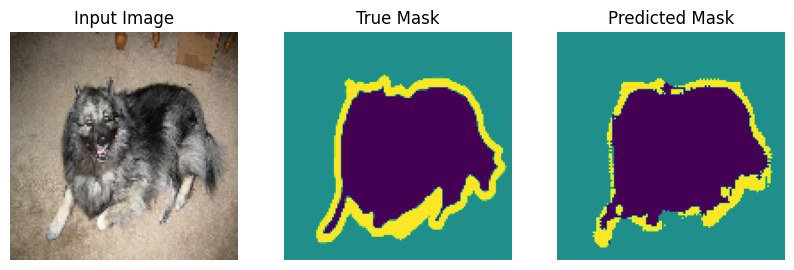

1/1 [==============================] - 0s 79ms/step


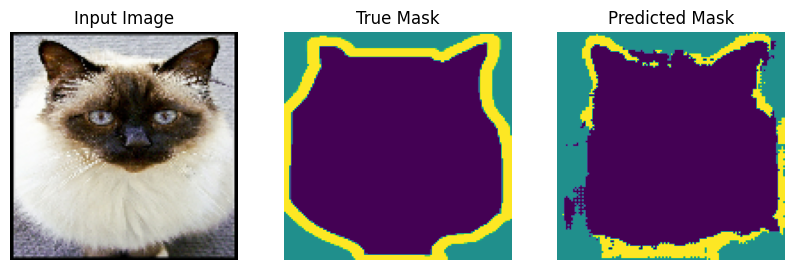

1/1 [==============================] - 0s 96ms/step


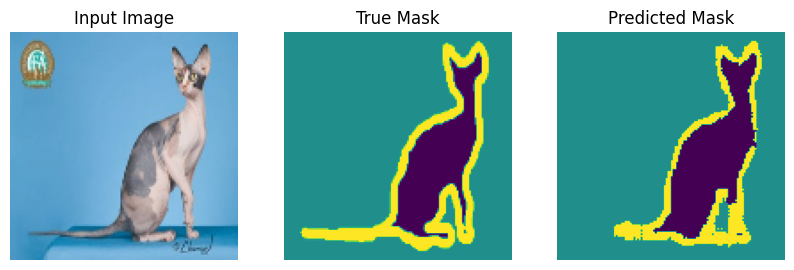

1/1 [==============================] - 0s 26ms/step


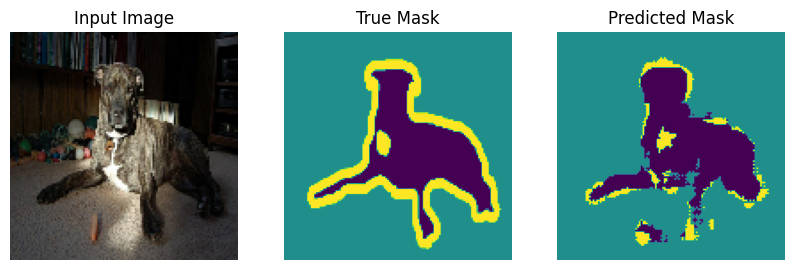

In [ ]:
show_predictions(test_dataset, 5)

### Выводы

Была реализована сегментация изображений домашних животных из датасета Oxford-IIIT Pet Dataset.

Oxford-IIIT Pet Dataset входит в набор датасетов TensorFlow и уже содержит необходимые тестовый и тренеровочный сплиты. Была проведена простая аугументация данных посредством переворота изображений.

Была использована модифицированная архитектура U-Net.  
Для ускорения процесса обучения в качестве энкодера использован предобученный MobileNetV2.  
Для декодера, использован повышающий дискретизацию блок из Pix2pix.

Для обучении модели была выбрана функция потерь `SparseCategoricalCrossentropy(from_logits=True)`и метрика `accuracy`.

Примерно после десятой эпохи обучения accuracy начинаиет уменьшаться и наблюдается переобучение модели.  
Лучший результат на 10 эпохах обучения accuracy = 0.8870